# Miniproject: Hopfield networks
### SCIPER: 308932

In [1]:
# start with importing the libraries we need

%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sympy, math
from sympy import *
import pandas as pd
import numpy as np
from neurodynex3.hopfield_network import pattern_tools, plot_tools, network
import neurodynex3.hopfield_network.pattern_tools as tools

## 1 Theory questions

## 2 Capacity

**Question 2.2**: Firstly, we use the alternative more efficient way to store the patterns and compare it with the neurodynex version

In [4]:
class Hopfield_fast(network.HopfieldNetwork):
    def __init__(self, nr_neurons):
        super().__init__(nr_neurons)
    
    def store_patterns(self, pattern_list):
        # check if the input is a list or a numpy array
        if type(pattern_list) == list:
            pattern_list = np.array(pattern_list)
        pattern_list = pattern_list.reshape(pattern_list.shape[0],-1)
        pattern_size = pattern_list.shape[1]
        # fill in the following line for make the Hopfield_fast class to run
        self.weights = 1 / pattern_size  * np.einsum('mn,nk->mk', pattern_list.T, pattern_list) 
        np.fill_diagonal(self.weights, 0)

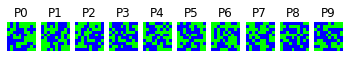

All the weights are the same:  True


In [5]:
# Before you continue test that your weights are correct (compare with the neurodynex version)

## we define the number of patterns as 10 to do a test
nr_patterns = 10 
## pattern size should be the square root of number of neurons
pattern_size = 10

## create an instance of the class HopfieldNetwork by neurodynex version
hopfield_net_class = network.HopfieldNetwork(nr_neurons= pattern_size**2)
## create an instance of the fast HopfieldNetwork by we defined above.
hopfield_net_fast=Hopfield_fast(nr_neurons=pattern_size**2)

## instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)

## Create the random patterns 
pattern_list = factory.create_random_pattern_list(nr_patterns, on_probability=0.5)
plot_tools.plot_pattern_list(pattern_list)

## let the hopfield network "learn" the patterns. 
hopfield_net_class.store_patterns(pattern_list)
hopfield_net_fast.store_patterns(pattern_list)

## test that your weights are correct (compare with the neurodynex version)
assert (hopfield_net_class.weights==hopfield_net_fast.weights).all()
print('All the weights are the same: ', (hopfield_net_class.weights==hopfield_net_fast.weights).all())

**Question 2.2**: Then, we can plot the probability for pattern p1 to be effectively stored decreases with the number of patterns P. We make the plot for these two hopfield networks and we can compare these results

In [11]:
# initializa some parameters

## pattern size should be the square root of number of neurons
pattern_size = 10
## times for run the hopfield_net, generate many random Hopfield networks to estimate the probability.
simulation_times_run_script=10000
## numpy array about number of patterns
pattern_iter=np.arange(1,101,1)

In [27]:
def calculate_probability(Network_type, pattern_iter, pattern_size, simulation_times_run_script):
    probability_results=np.zeros(pattern_iter.shape)
    
    for pattern_num, x in zip(pattern_iter, range(pattern_iter.shape[0])):
        
        ##create an instance of the class HopfieldNetwork
        if Network_type=='class':
            hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
        elif Network_type=='fast':
            hopfield_net = Hopfield_fast(nr_neurons= pattern_size**2)
        else:
            print(" network type error")
            
        ## instantiate a pattern factory
        factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
        ## define a calculator
        idx=0
        
        for i in range(simulation_times_run_script):
            ## Create the random patterns 
            pattern_list=factory.create_random_pattern_list(nr_patterns=pattern_num, on_probability=0.5)
            ## let the hopfield network "learn" the patterns. 
            hopfield_net.store_patterns(pattern_list)
            ## initialize with original pattern
            hopfield_net.set_state_from_pattern(pattern_list[0])
            ## from this initial state, let the network dynamics evolve. Because we fix the time steps as 5, so the number there is 5-4=1
            states = hopfield_net.run_with_monitoring(nr_steps=4)
            ## reshape the network to the same shape used to create the patterns.
            states_as_patterns = factory.reshape_patterns(states)
            
            # Calculate the overlap 
            overlaps_list = pattern_tools.compute_overlap_list(states_as_patterns[-1], pattern_list)
            max_overlap = np.argmax(overlaps_list)
            if (max_overlap == 0):
                idx += 1
        
        probability_results[x]=idx/simulation_times_run_script
        print("Probability for", pattern_num, "is", probability_results[x])
    return probability_results        

In [ ]:
probability_fast=calculate_probability("fast",pattern_iter,pattern_size, simulation_times_run_script)

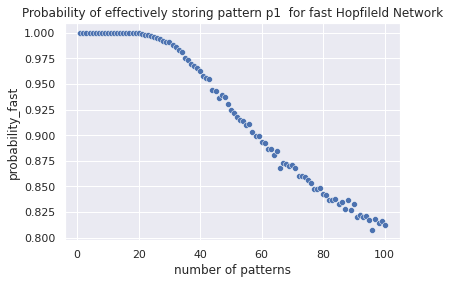

In [25]:
prob_fast_plot = pd.DataFrame({"number of patterns":pattern_iter, "probability_fast":probability_fast})
sns.scatterplot(x = "number of patterns", y = "probability_fast", data=prob_fast_plot)
sns.set(style='darkgrid',)
plt.title("Probability of effectively storing pattern p1  for fast Hopfileld Network")
plt.show()

In [29]:
## probability_class=calculate_probability("class",pattern_iter,pattern_size, simulation_times_run_script)

In [50]:
# plot the figure for probability for class Hopfileld Network
##prob_class_plot = pd.DataFrame({"number of patterns":pattern_iter, "probability_class":probability_class})
##sns.scatterplot(x = "number of patterns", y = "probability_class", data=prob_class_plot)
##sns.set(style='darkgrid',)
##plt.title("Probability of effectively storing pattern p1  for class Hopfileld Network")
##plt.show()


* Question 2.3 : In this part, we first calculate the empirical capacity and then compare with theoretical capacity

In [56]:
# the empirical capacity
C_em=sum(probability_fast>=0.99)/100
print("the empirical capacity is:", C_em)

# the theoretical capacity
## firstly, we want to the erf value is above 1-2/N=0.98.
## according to the function we find that the erf(1.7)>=0.98
x = Symbol('x')
f=exp(-x**2)*2/(math.sqrt(math.pi))
inte_part=integrate(f, (x, 0, 1.7)).evalf()
print(inte_part)

## So we calculete the theoretical capacity:
C_th=math.floor((100/(1.7*1.7*2)+1))/100
print("the theoretical capacity is:", C_th)


the empirical capacity is: 0.3
0.983790458590774
the theoretical capacity is: 0.18


## 3 From binary neurons to saturated rectified linear neurons.

**Question 3.1:** the graph of function g for $\beta =1$

In [58]:
# define the gain function with beta=1
def g(beta,h):
    out=np.minimum(1, np.maximum(-1, beta*h))
    return out

# assign the values of x-axis and y-axis
gx_values=np.linspace(-5, 5, 100)
gy_values=[g(1,i) for i in gx_values]
g_func_plot=pd.DataFrame({"h":gx_values, "g(h)":gy_values})

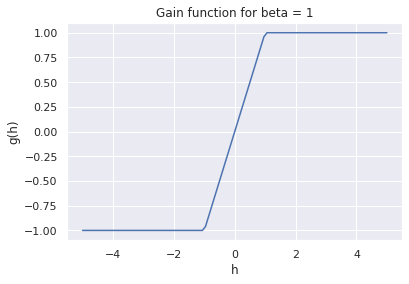

In [60]:
# plot the g function
sns.lineplot(x = "h", y = "g(h)", data=g_func_plot)
plt.title('Gain function for beta = 1')
plt.show()

**Question 3.2:**  theory questions

**Question 3.3:**  In this question, we need to consider the influence of steepness $\beta$ on the capacity of network. So, we plot the capacity as a function of $\beta$ . ** the update function is Synchronize，we can also use asychronize version**

In [66]:
#firstly, we define the synchronize update function:
def beta_update(beta):
    def network_update(state_s0, weights):
        h = np.sum(weights * state_s0, axis=1)
        g_h= np.minimum(1, np.maximum(-1, beta*h))
        state_s1=np.ones(g_h.shape)
        rand = np.random.uniform(0,1, g_h.shape)
        idx = g_h <= rand
        state_s1[idx] = -1
        return state_s1
    return network_update

def calculate_capacity(pattern_iter, pattern_size, simulation_times_run_script, betas, N):
    capacity_results=np.zeros(betas.shape)
    for b, x in zip(betas, range(betas.shape[0])):
        probability_results=np.zeros(pattern_iter.shape)
        for pattern_num, y in zip(pattern_iter, range(pattern_iter.shape[0])):
            # create an instance of the fast HopfieldNetwork
            hopfield_net = Hopfield_fast(nr_neurons= pattern_size**2)
            # set the update function
            hopfield_net.set_dynamics_to_user_function(beta_update(beta=b))
            #instantiate a pattern factory
            factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
            ## define a calculator
            idx=0
                   
            for i in range(simulation_times_run_script):
                ## Create the random patterns 
                pattern_list=factory.create_random_pattern_list(nr_patterns=pattern_num, on_probability=0.5)
                ## let the hopfield network "learn" the patterns. 
                hopfield_net.store_patterns(pattern_list)
                ## initialize with original pattern
                hopfield_net.set_state_from_pattern(pattern_list[0])
                ## from this initial state, let the network dynamics evolve. Because we fix the time steps as 5, so the number there is 5-4=1
                states = hopfield_net.run_with_monitoring(nr_steps=4)
                ## reshape the network to the same shape used to create the patterns.
                states_as_patterns = factory.reshape_patterns(states)
                   
                overlap_list = pattern_tools.compute_overlap_list(states_as_patterns[-1], pattern_list)
                max_overlap = np.argmax(overlap_list)
                if (max_overlap == 0): 
                    idx += 1
                   
            probability_results[y]=idx/simulation_times_run_script
        capacity_results[x]=sum(probability_results>=0.99)/N
        print('Beta='+str(b)+', Capacity='+str(capacity_results[x]))
    return capacity_results    


In [71]:
# Next, we define the initialize the beta value and patterns number list value
betas=np.arange(1,31,1)

pattern_iter=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50,60,70,80,90,100])

# define the other parameters:
simulation_times_run_script=1000
pattern_size=10
N=100

In [ ]:
capacity_results=calculate_capacity(pattern_iter, pattern_size, simulation_times_run_script, betas, N)

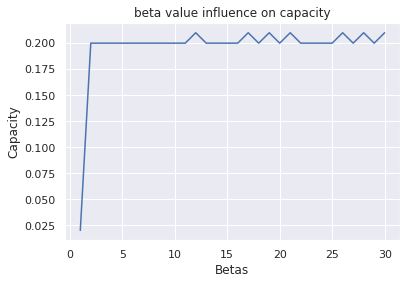

In [76]:
func_beta_plot=pd.DataFrame({"Betas":betas, "Capacity":capacity_results})
sns.lineplot(x = "Betas", y = "Capacity", data=func_beta_plot)
plt.title('beta value influence on capacity')
plt.show()


In [ ]:
small_betas=np.array([0.01,0.1,0.5,0.7])
capacity_results_small=calculate_capacity(pattern_iter, pattern_size, simulation_times_run_script, small_betas, N)

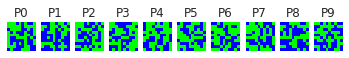

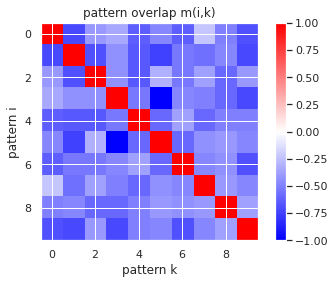

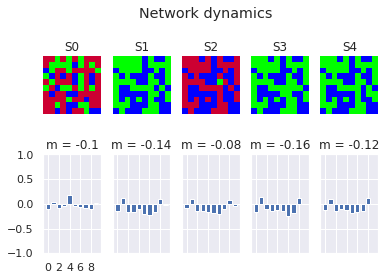

In [77]:
beta_ex = 0.1
pattern_size = 10
# create an instance of the fast HopfieldNetwork
hopfield_net = Hopfield_fast(nr_neurons= pattern_size**2)
# set the update function
hopfield_net.set_dynamics_to_user_function(beta_update(beta=beta_ex))
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)

pattern_list=factory.create_random_pattern_list(nr_patterns=10, on_probability=0.5)

plot_tools.plot_pattern_list(pattern_list)
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
plot_tools.plot_overlap_matrix(overlap_matrix)
hopfield_net.store_patterns(pattern_list)

#hopfield_net.set_state_from_pattern(pattern_list[0])

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=4)
# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics") 

## 4 Correlated patterns